In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/cell_images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=5,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

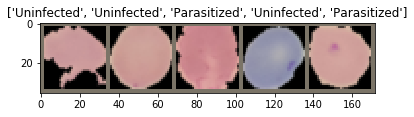

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
  
    scores = []
    train_loss = []
    val_loss = []
    
    scores_accuracy = []
    train_accuracy = []
    val_accuracy = []
    
    epoch_list = []
    
    for epoch in range(num_epochs):
        epoch_list.append(epoch)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            #Append training and validation scoores.
            scores.append(epoch_loss)   
            scores_accuracy.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Now distribute into train and val loss
        #Create train and test sets.
    for i in range(len(scores)):
        if i%2 ==0:
            print("i = ",i)
            train_loss.append(scores[i])
            train_accuracy.append(scores_accuracy[i])
        if i%2!=0:
            print("i = ",i)
            val_loss.append(scores[i]) 
            val_accuracy.append(scores_accuracy[i])
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    #Vis the accuracy curves.
    
    
    #Loss Curves.
    plt.subplot(211)
    plt.title('training and val loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('loss_curves.png')    
    plt.tight_layout()
    plt.plot(epoch_list, train_loss,label="training loss")    
    plt.plot(epoch_list ,val_loss, label ="validation loss")
    plt.legend(loc=1)
    plt.subplots_adjust(hspace=1)
    #Accuracy Curves.
    plt.subplot(212)
    plt.title('training and val accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(epoch_list ,train_accuracy , label ="training accuracy")
    plt.plot(epoch_list ,val_accuracy , label = "validation accuracy")
    plt.legend(loc=4)
    plt.savefig('accuracy_curves.png')
    
    print(best_model_wts['conv1.weight'].size()) # 4 layers to this network
    print(best_model_wts['conv2.weight'].size())
    
    fig = plt.figure()
    plt.figure(figsize=(10,10))
    for idx, filt  in enumerate(best_model_wts['conv1.weight']):
        #print(filt[0, :, :])
        plt.subplot(4,8, idx + 1)
        plt.imshow(filt[0, :, :])
        plt.axis('off')
    fig.savefig('demo11.png', bbox_inches='tight')
    
    fig = plt.figure()
    plt.figure(figsize=(10,10))
    for idx, filt  in enumerate(best_model_wts['conv2.weight']):
        #print(filt[0, :, :])
        plt.subplot(4,8, idx + 1)
        plt.imshow(filt[0, :, :])
        plt.axis('off')
    fig.savefig('demo12.png', bbox_inches='tight')
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
class SimpleNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=2)

        self.fc = nn.Linear(in_features=16 * 16 * 12, out_features=num_classes)

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)

        output = self.conv2(output)
        output = self.relu2(output)

        output = self.pool(output)

        output = output.view(-1, 16 * 16 * 12)

        output = self.fc(output)

        return output

In [ ]:
model_ft = SimpleNet(num_classes=2)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4421 Acc: 0.7837
val Loss: 0.2549 Acc: 0.9043
Epoch 1/9
----------
train Loss: 0.1826 Acc: 0.9326
val Loss: 0.1995 Acc: 0.9295
Epoch 2/9
----------
train Loss: 0.1547 Acc: 0.9448
val Loss: 0.2072 Acc: 0.9302
Epoch 3/9
----------
train Loss: 0.1473 Acc: 0.9481
val Loss: 0.1971 Acc: 0.9275
Epoch 4/9
----------
train Loss: 0.1425 Acc: 0.9501
val Loss: 0.1906 Acc: 0.9338
Epoch 5/9
----------
train Loss: 0.1376 Acc: 0.9502
val Loss: 0.1947 Acc: 0.9328
Epoch 6/9
----------
train Loss: 0.1367 Acc: 0.9522


In [ ]:
visualize_model(model_ft)